In [1]:
!gdown https://drive.google.com/drive/folders/1QGOx4H_bQHCdHmmOu2yt8mbmgqe8tMPq

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://drive.google.com/drive/folders/1QGOx4H_bQHCdHmmOu2yt8mbmgqe8tMPq
To: /content/1QGOx4H_bQHCdHmmOu2yt8mbmgqe8tMPq
273kB [00:00, 958kB/s]


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
%cd /content/
%ls


/content
1QGOx4H_bQHCdHmmOu2yt8mbmgqe8tMPq  drive/  sample_data/


In [5]:
!cp /content/drive/MyDrive/hymenoptera_data.zip .



In [6]:
!unzip hymenoptera_data.zip



Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [7]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

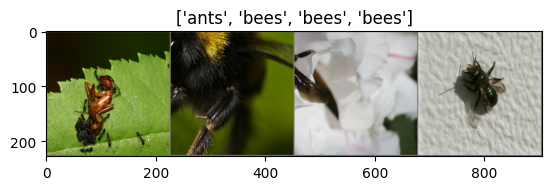

In [8]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:

import torchvision.models as models

# rest of your code here


model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)




device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6553 Acc: 0.6803
val Loss: 0.3834 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.4422 Acc: 0.8238
val Loss: 0.1888 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4939 Acc: 0.7992
val Loss: 0.4666 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.3926 Acc: 0.8607
val Loss: 0.2444 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.5018 Acc: 0.8156
val Loss: 0.2483 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.3628 Acc: 0.8402
val Loss: 0.5518 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.4345 Acc: 0.8197
val Loss: 0.3689 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4233 Acc: 0.8443
val Loss: 0.3309 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2913 Acc: 0.8689
val Loss: 0.3219 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3084 Acc: 0.8811
val Loss: 0.3117 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3142 Acc: 0.8852
val Loss: 0.2928 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.4216 Acc: 0.8074
val Loss: 0.2684 Acc: 0.9085

Ep

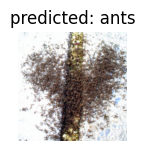

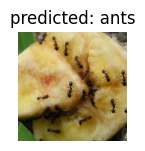

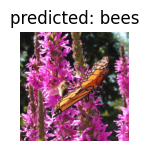

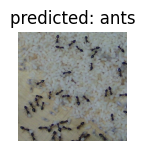

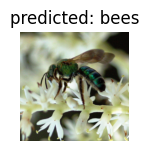

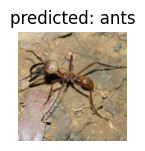

In [13]:
visualize_model(model_ft)

In [14]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6105 Acc: 0.6352
val Loss: 0.2628 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.6293 Acc: 0.7336
val Loss: 0.1837 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4001 Acc: 0.8156
val Loss: 0.1652 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4324 Acc: 0.8074
val Loss: 0.1646 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4253 Acc: 0.7992
val Loss: 0.1624 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4955 Acc: 0.7910
val Loss: 0.2557 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4468 Acc: 0.7910
val Loss: 0.1835 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3545 Acc: 0.8320
val Loss: 0.1881 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3625 Acc: 0.8361
val Loss: 0.1696 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3200 Acc: 0.8484
val Loss: 0.1902 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3311 Acc: 0.8689
val Loss: 0.1751 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2852 Acc: 0.8607
val Loss: 0.2089 Acc: 0.9216

Ep

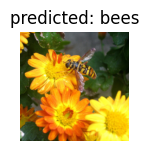

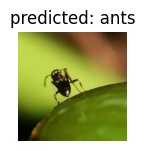

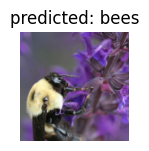

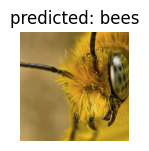

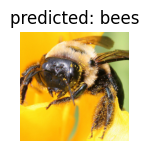

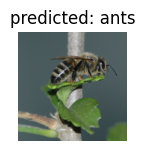

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()